In [ ]:
# pip install tabulate

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imgkit

# Importar el dataset
dataset = pd.read_csv("bike_sharing_for_hour_dataset.csv")

# Seleccionar las columnas de interés
columns = ["instant", "weekday", "workingday", "weathersit", "atemp", "windspeed", "hum", "casual", "registered", "cnt"]
df = dataset[columns]

In [38]:
# configurar estilo de las gráficas
sns.set(style="darkgrid")

In [39]:
df.describe()

,instant,weekday,workingday,weathersit,atemp,windspeed,hum,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,3.003683,0.682721,1.425283,0.475775,0.190098,0.627229,35.676218,153.786869,189.463088
std,5017.0295,2.005771,0.465431,0.639357,0.171850,0.122340,0.192930,49.305030,151.357286,181.387599
min,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,1.000000,0.000000,1.000000,0.333300,0.104500,0.480000,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,1.000000,0.484800,0.194000,0.630000,17.000000,115.000000,142.000000
75%,13034.5000,5.000000,1.000000,2.000000,0.621200,0.253700,0.780000,48.000000,220.000000,281.000000
max,17379.0000,6.000000,1.000000,4.000000,1.000000,0.850700,1.000000,367.000000,886.000000,977.000000


In [35]:
#Tabla correlacional a HTML
df.corr()['cnt'].to_frame()


,cnt
instant,0.278379
weekday,0.026900
workingday,0.030284
weathersit,-0.142426
atemp,0.400929
windspeed,0.093234
hum,-0.322911
casual,0.694564
registered,0.972151
cnt,1.000000


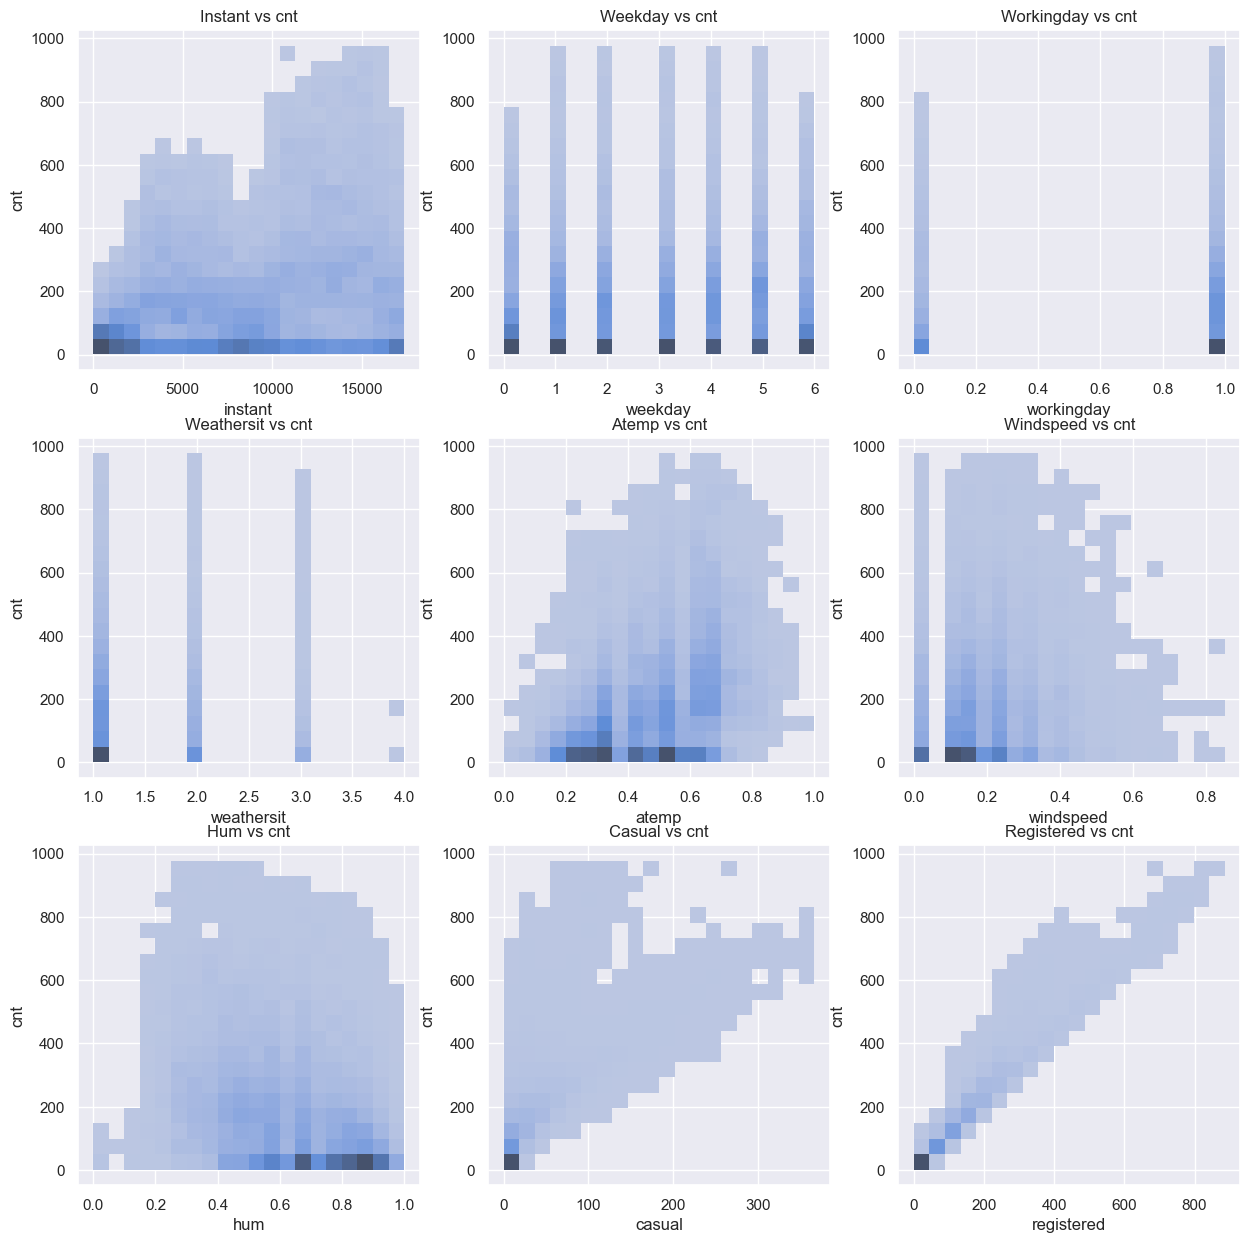

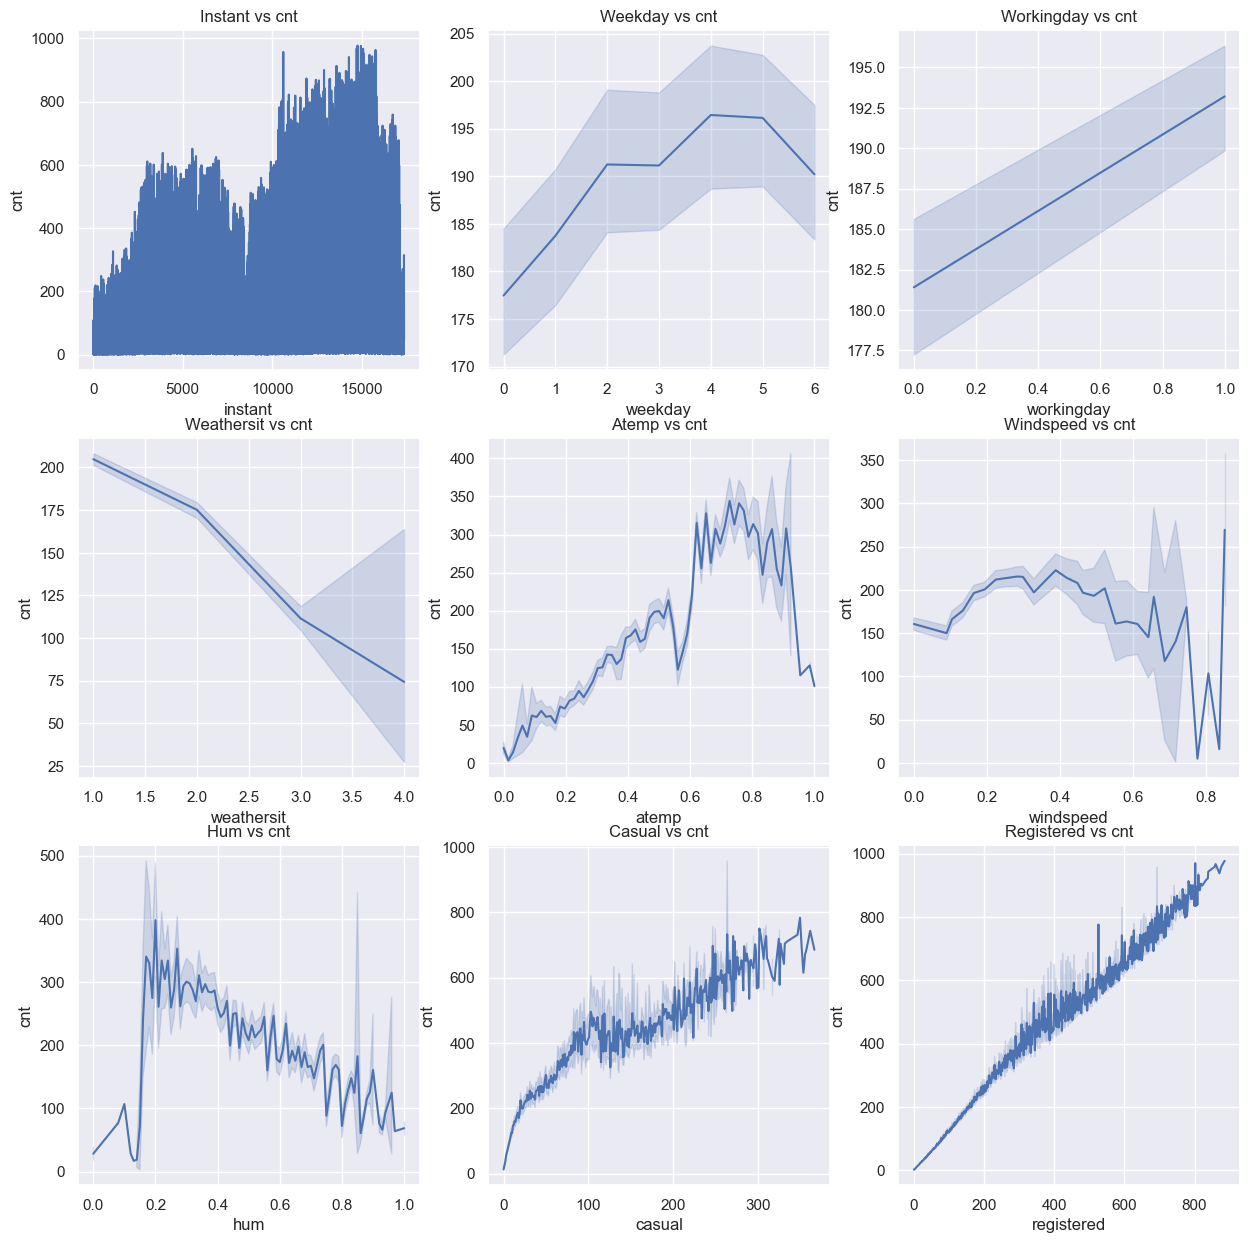

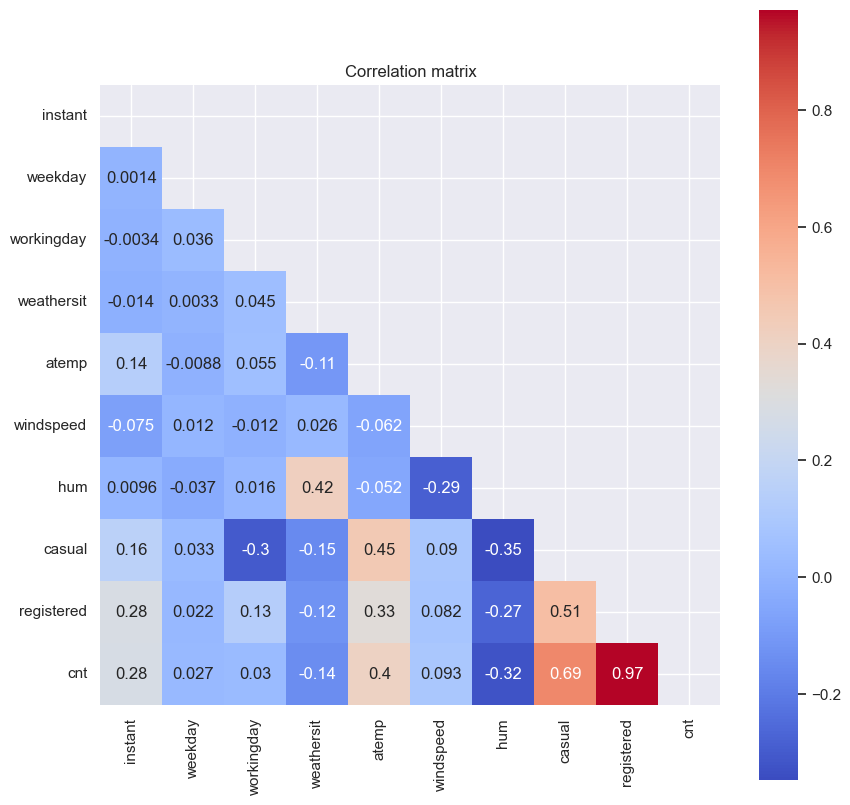

In [44]:
# crear figura y ejes para histogramas
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axs = axs.ravel()

# crear histogramas y configurar cada uno
for i, col in enumerate(columns[:-1]):
    sns.histplot(data=df, x=col, y="cnt", ax=axs[i], bins=20)
    axs[i].set_title(f"{col.capitalize()} vs cnt")

# crear figura y ejes para plots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axs = axs.ravel()

# crear plots y configurar cada uno
for i, col in enumerate(columns[:-1]):
    sns.lineplot(data=df, x=col, y="cnt", ax=axs[i])
    axs[i].set_title(f"{col.capitalize()} vs cnt")

# crear figura y ejes para matriz de correlación
fig, ax = plt.subplots(figsize=(10, 10))

# crear matriz de correlación y configurar
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", square=True, ax=ax)
ax.set_title("Correlation matrix")

# mostrar todas las figuras
plt.show()